# Prototyping Actor-Critic algorithms in LunarLander-v2 environment (A2C)

In [141]:
import gym
import torch
env = gym.make('CartPole-v0')
print(env.observation_space)
print(env.action_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Discrete(2)


In [44]:
import numpy as np
probs = np.array([0.5, 0.25, 0.25])
np.random.choice(3, p = probs)

0

# Steps:

1. play n steps in the environment and save (state, action, next_state), default N = ?
2. Initialize R = 0 or R = V(St)
3. calculate loss = td_loss + policy_gradient + (entropy_loss)
4. update params
5. repeat


# Programming steps:
1. ExpSource step return discounted reward state and action, paramas = n_step, net
2. function to transform list of experiences into batch of states actions and reward (non terminal state rewards summed with value net output)
3. functions to calculate approriate losses
4. take optimizer step
5. incorporate logger into the mix
6. try to implement experience source with multiple environments


In [210]:
#define experience source 
from collections import namedtuple
import numpy as np
import torch.nn.functional as F
from utils import Experience

#PolicyExperience = namedtuple('PolicyExperience', ('state', 'action', 'reward', 'isdone'))

"""
step returns experience with n_step unroll 

"""
class SamplingPolicy:
    
    def __init__(self, net):
        
        self.net = net
        
    @torch.no_grad()
    def get_action(self, state):
        """
        get sampled action from state
        currently supports only single action at a time
        """
        
        logits, _ = self.net(state)
        output_dim = logits.shape[1]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        #print(probs)
        return np.random.choice(output_dim, p=probs[0])
    
    def __call__(self, state):
        return self.net(state)

class SamplingSinglePolicy(SamplingPolicy):
    
    def __init__(self, net):
        super().__init__(net)
        
    @torch.no_grad()
    def get_action(self, state):
        logits = self.net(state)
        output_dim = logits.shape[1]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        #print(probs)
        return np.random.choice(output_dim, p=probs[0])
    
class ExperienceSourceForPolicy:
    
    def __init__(self, env, n_steps, gamma = 0.99, device="cpu"):
        
        self.env = env
        self.state = self.env.reset()
        
        self.episode_reward = 0
        self.episode_steps = 0
        
        self.n_steps = n_steps
        
        self.device = device
        self.steps_done = 0
        
        self.gamma = gamma
        
        
    @torch.no_grad()
    def step(self, policy):
        
        state = self.state
        obs_tens = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        act = policy.get_action(obs_tens)
        
        obs, reward, isdone, _ = self.env.step(act)
        
        self.episode_steps +=1
        self.episode_reward+=reward
        
        first_action = act
        total_reward = reward
        
        if (not isdone):
            for i in range(self.n_steps-1):
                obs_tens = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
                act = policy.get_action(obs_tens)
                obs, reward, isdone, _ = self.env.step(act)
                total_reward+=(self.gamma**(i+1))*reward
                self.episode_reward+=reward
                self.episode_steps+=1
                if isdone: 
                    break
                    
        exp = Experience(state, first_action, obs, total_reward, isdone)
        
        if isdone:
            self.state=self.env.reset()
            episode_reward = self.episode_reward
            episode_steps = self.episode_steps
            
            self.episode_steps = 0
            self.episode_reward = 0
                
            return exp, (episode_reward, episode_steps)
        
        
        self.state = obs
        
        return exp, None
        
        
        


In [232]:
# Define Model
import torch
import torch.nn as nn

class A2CBasicNet(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size = 256):
        
        super(A2CBasicNet, self).__init__()
        self.base = nn.Sequential(nn.Linear(input_dim, hidden_size), 
                                  nn.ReLU(), nn.Linear(hidden_size, hidden_size),
                                  nn.ReLU(), nn.Linear(hidden_size, hidden_size),
                                  nn.ReLU()
                                 )
        
        self.policy = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(), nn.Linear(hidden_size, output_dim)
                                   )
        self.value = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                   nn.ReLU(), nn.Linear(hidden_size, 1)
                                  )
        
    def forward(self, input):
        x = self.base(input)
        policy_logits = self.policy(x)
        value = self.value(x)
        return policy_logits, value
    

class PolicyNet(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size = 512):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.ELU(),
                                 nn.Linear(hidden_size, hidden_size), nn.ELU(),
                                 nn.Linear(hidden_size, output_dim)
                                )
    def forward(self, input):
        return self.net(input)
    
class ValueNet(nn.Module):
    
    def __init__(self, input_dim, hidden_size = 512):
        super(ValueNet,self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.ELU(),
                         nn.Linear(hidden_size, hidden_size), nn.ELU(),
                         nn.Linear(hidden_size, 1)
                        )
    def forward(self, input):
        return self.net(input)
    
net = PolicyNet(8,4)
policy = SamplingSinglePolicy(net)
policy.get_action(torch.randn(1, 8))

3

In [115]:
mask = np.array([True, False, True])
print(mask)
print(np.logical_not(mask))

[ True False  True]
[False  True False]


In [238]:
# define utils

import timeit

def get_batch(batch, net, n_steps, gamma=0.99):
    """
    return tensors:
    states, actions, 
    """
    
    states, acts, next_states, rewards, isdones = zip(*batch)
    states, acts, next_states, rewards, isdones = np.stack(states), np.stack(acts), np.stack(next_states), np.stack(rewards), np.stack(isdones)
    done_mask = np.logical_not(isdones)
    #print(acts.shape)
    #print(done_mask.shape)
    
    tens = torch.FloatTensor(next_states[done_mask])
    Q_vals = net(tens)
    #print(Q_vals.shape)
    #print(rewards.shape)
    rewards[done_mask] = rewards[done_mask]+Q_vals.data.cpu().numpy()[:,0]*(gamma**n_steps)
    
    
    return torch.FloatTensor(states), torch.tensor(acts, dtype=torch.int64), torch.FloatTensor(rewards)

_, acts, vals = get_batch(bb, net, n_steps=4)
acts.shape

torch.Size([128])

In [247]:
# define training loop (Params From Deep Reinforcement Learning Hands-On, Maxim Lapan)
import time

gamma = 0.99
lr = 0.001
beta = 0.005
batch_size = 32
num_envs = 50
sync_interval = 1000

reward_steps = 4
clip_grad = 0.1

env = gym.make('LunarLander-v2')
policy_net = PolicyNet(8, 4)
value_net = ValueNet(8)
target_value_net = ValueNet(8)
target_value_net.load_state_dict(value_net.state_dict())




policy = SamplingSinglePolicy(policy_net)
exp_source = ExperienceSourceForPolicy(env, n_steps = reward_steps)

policyoptimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
valueoptimizer = torch.optim.Adam(value_net.parameters(), lr=lr)
episode_rewards = []
episodes_done=0
batch = []
best = -200
num_steps = 0

start_time = time.time()
print("start training")
while True:
    exp, rew = exp_source.step(policy)
    batch.append(exp)
    if rew!=None:
        reward, steps = rew
        episode_rewards.append(reward)
        if len(episode_rewards)%10==0 and len(episode_rewards) > 0:
            if sum(episode_rewards[-10:])/10 > best:
                print(sum(episode_rewards[-10:])/10)
                print(len(episode_rewards))
                print(time.time()-start_time)
                best = sum(episode_rewards[-10:])/10
                print(35*'-')
            if sum(episode_rewards[-10:])/10 > 199:
                print("Solved")
                break
                
    if len(batch) == batch_size:
        
        num_steps+=1
        
        states, acts, rewards = get_batch(batch, target_value_net, n_steps=reward_steps)
        batch.clear()
        optimizer.zero_grad()
        
        logits = policy_net(states)
        vals = value_net(states)
        
        value_loss = F.mse_loss(vals.squeeze(-1), rewards)
        
        log_probs = F.log_softmax(logits, dim=1)
        adv_v = rewards-vals.detach()
        log_p_a = log_probs[range(batch_size), acts]
        
        policy_loss = -(adv_v*log_p_a).mean()
        
        #policy_loss.backward(retain_graph=True)
        
        probs = F.softmax(logits, dim=1)
        ent = (probs*log_probs).sum(dim=1).mean()
        
        entropy_loss = beta*ent
        
        p_loss = policy_loss+entropy_loss
        
        p_loss.backward()
        value_loss.backward()
                
            
        nn.utils.clip_grad_norm_(policy_net.parameters(), clip_grad)
        nn.utils.clip_grad_norm_(value_net.parameters(), clip_grad)
        
        policyoptimizer.step()
        valueoptimizer.step()
        

        #optimizer.step()
        if num_steps%sync_interval == 0:
            target_value_net.load_state_dict(value_net.state_dict())

        
        
        # Handlebatching 
        #calculate policy loss
        #calculate value loss
        #calculate entropy loss

            # update parameters
            

    
    

start training
-173.87932291996913
20
0.8780007362365723
-----------------------------------
-104.37170245074972
30
1.0890302658081055
-----------------------------------
-81.60636759162655
130
3.1410117149353027
-----------------------------------
-70.03442752123473
540
17.21089458465576
-----------------------------------
-48.4820518654886
580
22.141947269439697
-----------------------------------
40.894906788763116
640
58.271281480789185
-----------------------------------
139.96941866297087
660
61.68534469604492
-----------------------------------
205.34771360614522
1080
180.7928123474121
-----------------------------------
Solved


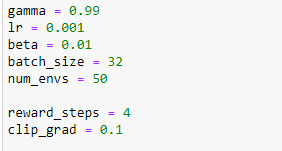

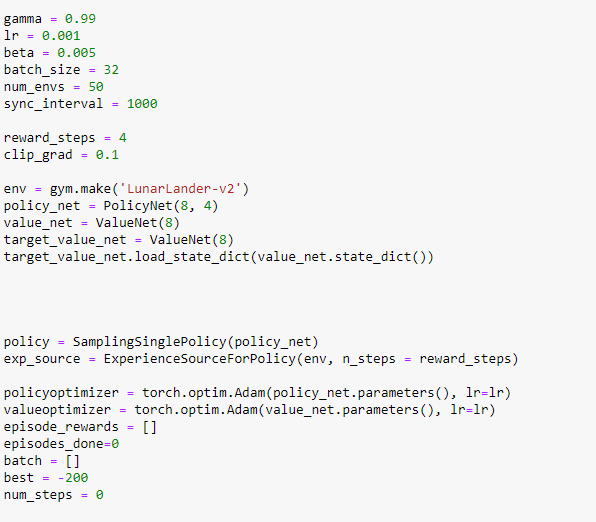

In [248]:
from video_tools import show_epi

env = gym.make('LunarLander-v2')
show_episode(policy_net, env, save_video=True, video_path="LunarLanderA2C.mp4", images_path="lunarlander_images")

SyntaxError: invalid syntax (<ipython-input-248-2e5d3e5eadfd>, line 1)